## Content Based Recommendation System for Hikes

This project creates two different content based recommendation systems.

Both start by creating a small, filtered dataset from results provided by the REI API. These results are filtered based on the user's location, desired length of hike, and maximum driving distance.

The first recommender takes these filtered preferences and a hike that the user enjoys and creates recommendations that are similar to the user-provided hike.

The second system takes the filtered preferences and some keywords from the user such as 'breathtaking', 'good views' or 'challenging' and return hikes that have similar descriptions to these keywords.

The information in this dataset was queried from the free API provided by REI co-op.

You can find information on their API [here](https://www.hikingproject.com/data).

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
import config
warnings.filterwarnings('ignore')

## Hiking Project

First, we will load our datasets from our API queries. The actual requests can be found in the 'Hiking - Get Requests.ipynb' notebook.

I did several different requests at different times. That's why I need to load both, and then combine before continuing.

In [2]:
#load our first get request
trail_df = pd.read_csv('hiking.csv')

In [3]:
#load our second csv get request call
trail_df_two = pd.read_csv('hiking_two.csv')

In [4]:
#add our two requests together
trail_df = trail_df.append(trail_df_two, ignore_index=True)

In [5]:
trail_df.head(2)

,id,name,summary,difficulty,stars,star_votes,location,url,length,ascent,descent,high,low,longitude,latitude,cond_status,cond_details,cond_date
0,7003796,Section 16/Palmer Loop,A favorite loop in the Springs area.,blue,4.5,72,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,5.9,1287,-1288,7845,6633,-104.8903,38.8228,All Clear,NaN,2019-09-19 15:04:39
1,7006769,Castlewood Canyon - Rimrock to Creek Bottom Loop,"A fun, rolling trail with a sense of seclusion...",blue,4.6,45,"Castle Rock, Colorado",https://www.hikingproject.com/data/,4.6,610,-612,6561,6163,-104.7682,39.3598,Minor Issues,Snowy - Still a few slippery patches on rocky ...,2019-10-12 12:44:28


Ok, these are all together.

Let's do some basic exploration of our dataset!

In [6]:
#unique by column
for column in trail_df.columns:
    print('{} unique values: {}'.format(column, trail_df[column].nunique()))

id unique values: 13945
name unique values: 12764
summary unique values: 9394
difficulty unique values: 7
stars unique values: 35
star_votes unique values: 97
location unique values: 1984
url unique values: 1
length unique values: 427
ascent unique values: 3248
descent unique values: 2632
high unique values: 7363
low unique values: 6673
longitude unique values: 12599
latitude unique values: 12182
cond_status unique values: 4
cond_details unique values: 551
cond_date unique values: 1611


__I would guess that there are a lot of duplicate hikes in our df. Let's see if we can find any.__

In [7]:
test_dup_name = trail_df.name[0]

trail_df.loc[trail_df.name == test_dup_name].reset_index(drop=True)[:5]

,id,name,summary,difficulty,stars,star_votes,location,url,length,ascent,descent,high,low,longitude,latitude,cond_status,cond_details,cond_date
0,7003796,Section 16/Palmer Loop,A favorite loop in the Springs area.,blue,4.5,72,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,5.9,1287,-1288,7845,6633,-104.8903,38.8228,All Clear,NaN,2019-09-19 15:04:39
1,7003796,Section 16/Palmer Loop,A favorite loop in the Springs area.,blue,4.5,72,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,5.9,1287,-1288,7845,6633,-104.8903,38.8228,All Clear,NaN,2019-09-19 15:04:39
2,7003796,Section 16/Palmer Loop,A favorite loop in the Springs area.,blue,4.5,72,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,5.9,1287,-1288,7845,6633,-104.8903,38.8228,All Clear,NaN,2019-09-19 15:04:39
3,7003796,Section 16/Palmer Loop,A favorite loop in the Springs area.,blue,4.5,72,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,5.9,1287,-1288,7845,6633,-104.8903,38.8228,All Clear,NaN,2019-09-19 15:04:39
4,7003796,Section 16/Palmer Loop,A favorite loop in the Springs area.,blue,4.5,72,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,5.9,1287,-1288,7845,6633,-104.8903,38.8228,All Clear,NaN,2019-09-19 15:04:39


__Oh yes, there are lots of duplicates. Let's correct that beofre moving on to our EDA.__

In [8]:
df = pd.DataFrame(columns=trail_df.columns)

for trail in trail_df.name.unique().tolist():
    temp_df = trail_df.loc[trail_df.name == trail].reset_index()
    df = df.append(temp_df.loc[0, :], ignore_index=True)
    
df.head()

,id,name,summary,difficulty,stars,star_votes,location,url,length,ascent,descent,high,low,longitude,latitude,cond_status,cond_details,cond_date,index
0,7003796,Section 16/Palmer Loop,A favorite loop in the Springs area.,blue,4.5,72,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,5.9,1287,-1288,7845,6633,-104.8903,38.8228,All Clear,NaN,2019-09-19 15:04:39,0.0
1,7006769,Castlewood Canyon - Rimrock to Creek Bottom Loop,"A fun, rolling trail with a sense of seclusion...",blue,4.6,45,"Castle Rock, Colorado",https://www.hikingproject.com/data/,4.6,610,-612,6561,6163,-104.7682,39.3598,Minor Issues,Snowy - Still a few slippery patches on rocky ...,2019-10-12 12:44:28,1.0
2,7022212,Garden of the Gods Loop,A longer loop in this spectacular area allows ...,greenBlue,4.1,45,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,4.0,414,-414,6588,6291,-104.8802,38.8815,All Clear,Dry,2019-08-10 15:45:14,2.0
3,7032321,Harrison Crash Site via Ice Cave,A truly beautiful hike following Ice Cave Cree...,blueBlack,4.9,15,"Palmer Lake, Colorado",https://www.hikingproject.com/data/,11.1,2066,-2065,8540,7231,-104.9213,39.1187,Unknown,NaN,1970-01-01 00:00:00,3.0
4,7018077,Mt. Muscoco,"Easily accessible from Colorado Spings, with v...",blue,4.4,28,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,2.0,1248,-17,7964,6733,-104.8871,38.7918,All Clear,Dry - Awesome Hike!,2019-09-02 21:52:17,4.0


__We don't want to repeat this process, so let's save this duplicate free df as a csv.__

In [9]:
df.to_csv('hiking_no_dups.csv', index=False)

# EDA

Now that we have our duplicate-free csv. Let's load it and continue with our EDA!

In [2]:
df = pd.read_csv('hiking_no_dups.csv')

In [3]:
len(df)

12764

Let's create new features for our city and state.

In [4]:
#new lists to create state and city specific
city = []
state = []

#seperate each city and state then append to our lists
for i in range(len(df)):
    city_state = df.location[i].split(',')
    city.append(city_state[0])
    state.append(city_state[1].strip())
    
#add our list to our df
df['city'] = city
df['state'] = state

In [5]:
df = df.drop(columns='index')
df.head(2)

,id,name,summary,difficulty,stars,star_votes,location,url,length,ascent,descent,high,low,longitude,latitude,cond_status,cond_details,cond_date,city,state
0,7003796,Section 16/Palmer Loop,A favorite loop in the Springs area.,blue,4.5,72,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,5.9,1287,-1288,7845,6633,-104.8903,38.8228,All Clear,NaN,2019-09-19 15:04:39,Manitou Springs,Colorado
1,7006769,Castlewood Canyon - Rimrock to Creek Bottom Loop,"A fun, rolling trail with a sense of seclusion...",blue,4.6,45,"Castle Rock, Colorado",https://www.hikingproject.com/data/,4.6,610,-612,6561,6163,-104.7682,39.3598,Minor Issues,Snowy - Still a few slippery patches on rocky ...,2019-10-12 12:44:28,Castle Rock,Colorado


There are not too many null values. We'll have to take a deeper dive to confirm.

In [6]:
df.isnull().sum() / len(df) * 100

id               0.000000
name             0.000000
summary          6.972736
difficulty       0.000000
stars            0.000000
star_votes       0.000000
location         0.000000
url              0.000000
length           0.000000
ascent           0.000000
descent          0.000000
high             0.000000
low              0.000000
longitude        0.000000
latitude         0.000000
cond_status      0.000000
cond_details    88.569414
cond_date        0.000000
city             0.000000
state            0.000000
dtype: float64

__It's reasonable to remove the entire cond_details column. Then remove any rows missing a summary (~7% of our dataset)__

In [7]:
df = df.drop(columns='cond_details')
df = df.dropna().reset_index(drop=True)

Let's split our dataset into our categorical and numeric features and then visualize the results.

In [8]:
df['length'].describe()

count    11874.000000
mean         4.899992
std          9.488352
min          0.000000
25%          1.100000
50%          2.500000
75%          5.500000
max        261.000000
Name: length, dtype: float64

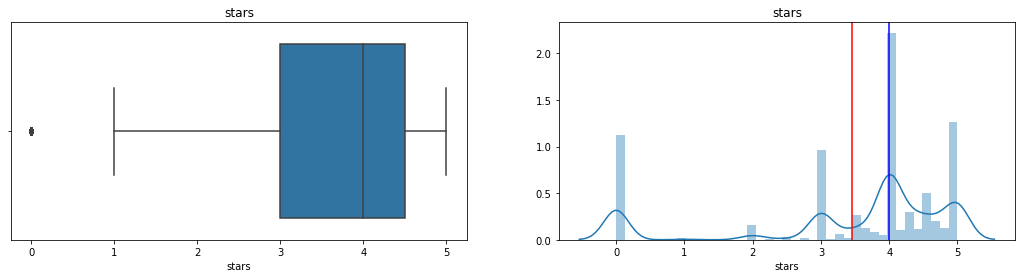

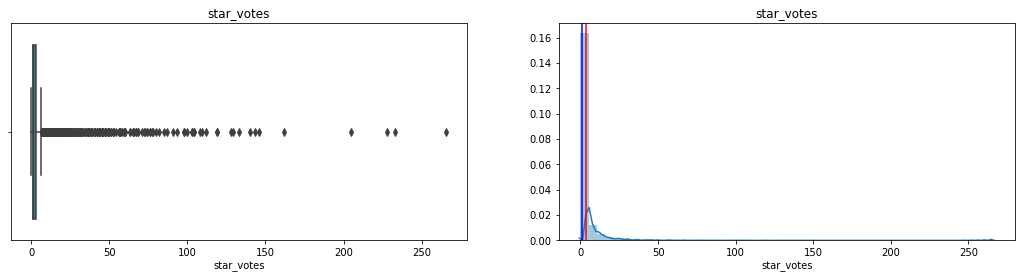

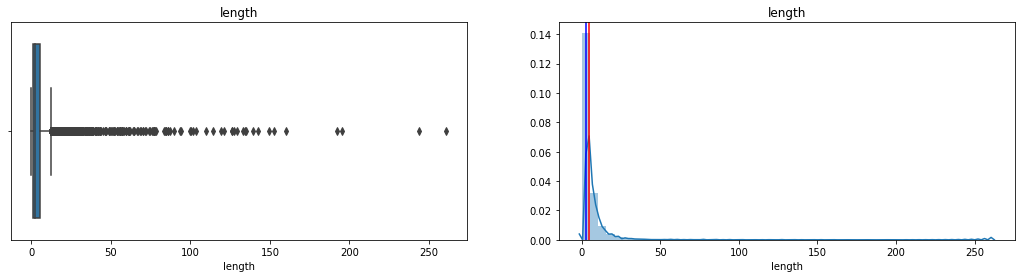

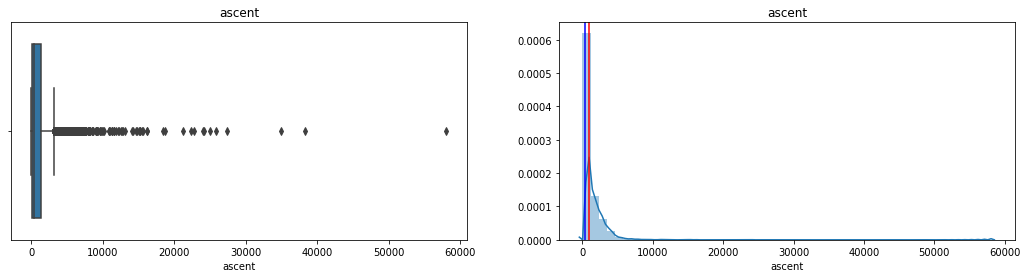

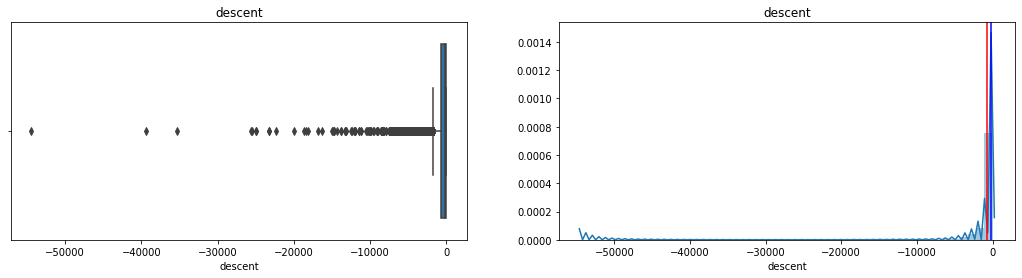

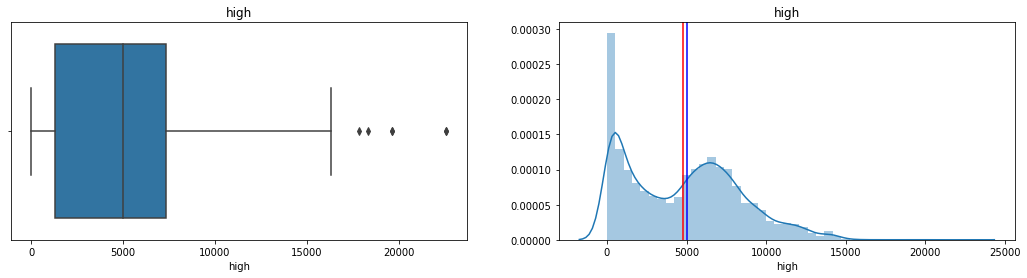

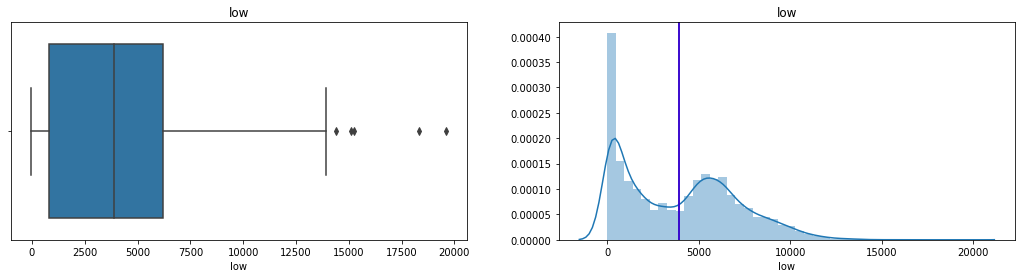

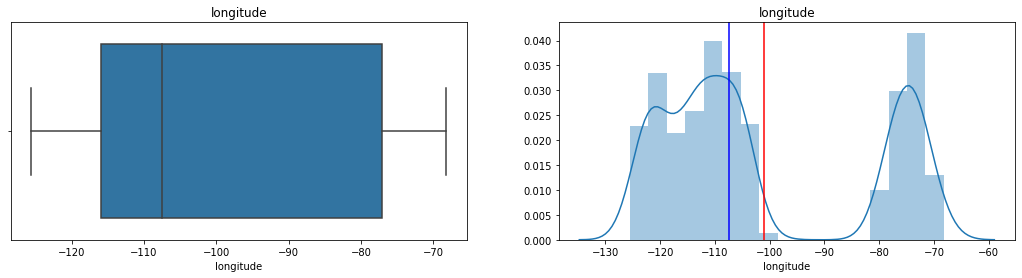

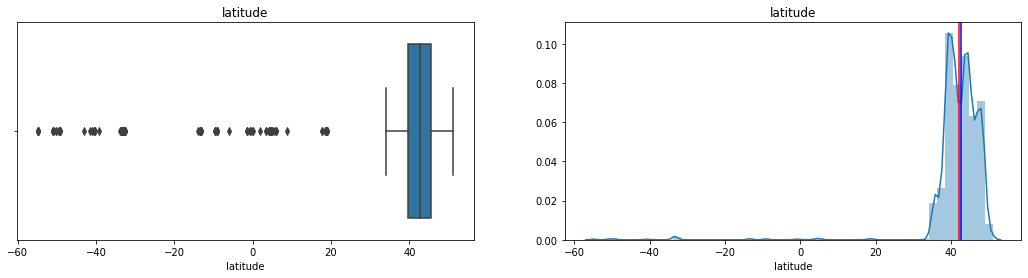

In [9]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
cat_df = df.loc[:, ~df.columns.isin(numeric_df.columns)]

for column in numeric_df.columns:
    if column != 'id':
        plt.figure(figsize=(18, 4))
        
        plt.subplot(1, 2, 1)
        sns.boxplot(df[column])
        plt.title('{}'.format(column))
        
        plt.subplot(1, 2, 2)
        sns.distplot(df[column])
        plt.axvline(df[column].mean(), color='red')
        plt.axvline(df[column].median(), color='blue')
        plt.title('{}'.format(column))
        
        plt.show()

A couple of findings:

    1) The 'high'/'low' & 'ascent'/'descent' features seem to be inverses. Not surprising as most hikes are loops.
    2) There are definitely some outliers - especially in the lengty category.
    3) Most hikes are rated fairly well! About 4 stars for the average.

Now, onto our categorical features.

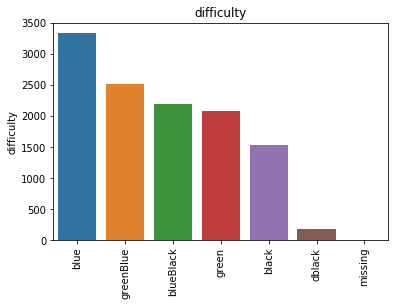

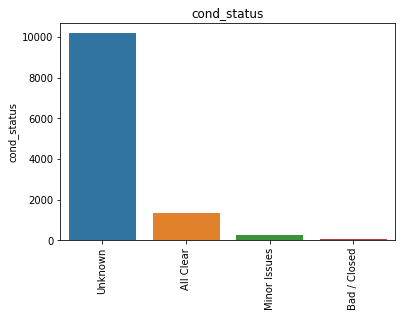

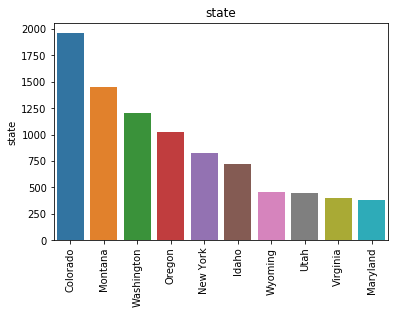

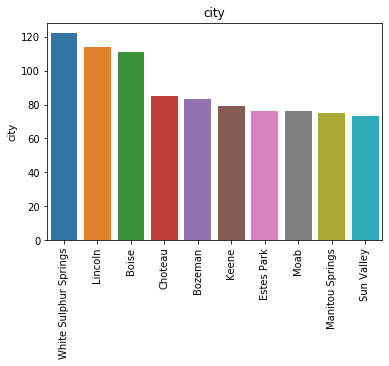

In [10]:
cat = ['difficulty', 'cond_status', 'state', 'city']

for column in cat:
    names = list(df[column].value_counts().index[:10])
    value = df[column].value_counts()[:10]
    plt.title('{}'.format(column))
    sns.barplot(names, value)
    plt.xticks(rotation='vertical')
    plt.show()

There are a decent amount of essentially null values in some of these features. It's good to be aware of this before moving forward.

We also know that our difficulty category is ranked, so let's look at this new feature from a different lens.

In [11]:
df.difficulty.value_counts()

blue         3336
greenBlue    2522
blueBlack    2205
green        2092
black        1530
dblack        176
missing        13
Name: difficulty, dtype: int64

In [12]:
difficulties = ['green', 'greenBlue', 'blue', 'blueBlack', 'black', 'dblack']

#our function returns the index (from 0 - 5) or null
def convert_difficulty(value):
    if value in difficulties:
        return difficulties.index(value)
    else:
        return np.nan

df['diff_ranked'] = df['difficulty'].apply(lambda x: convert_difficulty(x))

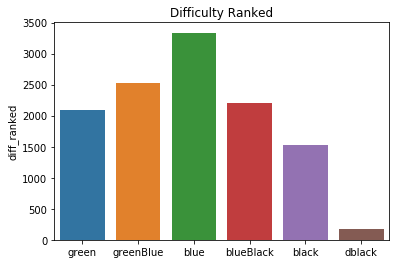

In [13]:
names = df.diff_ranked.value_counts().sort_index().index
values = df.diff_ranked.value_counts().sort_index()

sns.barplot(names, values)
plt.xticks(np.arange(6) ,difficulties)
plt.title('Difficulty Ranked')
plt.show()

So, our largest segement is our blue or 'average' hikes. Then our values fan out from there.

# Summary EDA

Let's take a deeper dive into our summary values. I wonder what we'll find...

In [14]:
for  i in range(10):
    print(df['summary'][i])

A favorite loop in the Springs area.
A fun, rolling trail with a sense of seclusion, great geology, and historical sites.
A longer loop in this spectacular area allows hikers to take in the highlights without the crowds.
A truly beautiful hike following Ice Cave Creek and Levi Creek, then following a ridge to the Harrison plane crash.
Easily accessible from Colorado Spings, with views of the city and 360° mountain views from the top.
An excellent, but short, loop through the heart of Garden of the Gods.
A hike with creeks, bridges, scree slopes, forested paths, summit to Mount Rosa, then finishing with St. Mary Falls.
A solid ascent along the ridge northwest of the upper reservoir and descending the old Winding Staircase-beautiful views
Widely recognized as one of the best urban trails in the country.
This 750 acre park features geological formations including spires, chasms, and gullies.


These appear to be straightforward English (no emojis, obscure slang, etc.)

In [15]:
summary_length = []

for i in range(len(df['summary'])):
    summary_length.append(len(df['summary'][i]))
    
print('Our df has {} records and we have {} summary lengths.'.format(len(df), len(summary_length)))
print('The average is {} and the median is {} --- std {}'.format(np.mean(summary_length), np.median(summary_length), np.std(summary_length)))

Our df has 11874 records and we have 11874 summary lengths.
The average is 57.374094660603 and the median is 60.0 --- std 33.48130321199061


In [16]:
df['summary_length'] = df['summary'].apply(lambda x: len(x))

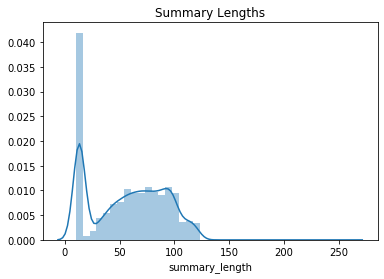

In [17]:
sns.distplot(df['summary_length'])
plt.title('Summary Lengths')
plt.show()

Hmm there appears to be a lot of lengths with the exact same value. Let's see if there is something else going on here.

In [18]:
for i in range(int(len(df['summary']) / 50)):
    if len(df['summary'][i]) == 13:
        print(df['summary'][i])

To be written
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary


Whoa! These 'Needs Summary' descriptions are essentially empty. I wonder if there are more like it.

In [19]:
df['summary'] = df['summary'].str.lower()
needs_summary = df.loc[df.summary.str.contains('summary')]
needs_summary.summary.value_counts()

needs summary                                 2698
needs summary and description.                  30
this trail could use a short summary!           14
needs summary.                                   6
this trail needs a summary!                      2
needs summary!                                   1
needs summary and an expanded description.       1
summary here.                                    1
this trail could use a summary!                  1
this trail needs a summary                       1
Name: summary, dtype: int64

Yep! All of these do not convery any real information (other than its missing). I wonder if there are more summaries like this.

Let's take a look at the small ones.

In [20]:
small_summaries = df.loc[df.summary_length <= 20]

small_summaries.summary.value_counts()[:10]

needs summary        2698
needs adoption        347
needs adoption!        26
coming soon            11
adopt me, please!       9
adopt this trail!       8
to be written           7
needs adoption.         6
needs summary.          6
to be completed         2
Name: summary, dtype: int64

In [21]:
needs_adoption = df.loc[df.summary.str.contains('adopt')]
needs_adoption.summary.value_counts()

needs adoption       347
needs adoption!       26
adopt me, please!      9
adopt this trail!      8
needs adoption.        6
adopt me please!       1
Name: summary, dtype: int64

Ok, the 'needs adoption' need to be handled as well.

We'll remove any records that have either 'summary' or 'adoption'.

In [22]:
df['summary'] = df['summary'].apply(lambda x: np.nan if 'summary' in x or 'adopt' in x else x)

In [23]:
df = df.dropna().reset_index(drop=True)

# Creating our filtered subsets.

This will be a 2 step-process:

    1) Query the database based on user input (location, driving distance, trail length)
    2) Clean the dataset and create an extra feature (make all lowercase, remove 'summary', etc.)

In [24]:
#we'll want to do some light cleaning of the text before we use it as a feature
import re

def text_cleaner(text):
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

df['sent_combined'] = df['summary'] + ' ' + df['difficulty']
df['sent_combined'] = df['sent_combined'].apply(lambda x: text_cleaner(x))

## Filter Combined with Get Request

We need the lat/long to do our API query. It's unlikely that people know their current lat/long. So we'll take the city and state as input and return the latitude and longitude.

Found this Lat/Long dataset provided by the USGS. [here](https://simplemaps.com/data/us-cities).

In [25]:
cities_df = pd.read_csv('uscities.csv')

In [26]:
#drop some unnecessary columns
cities_df = cities_df.drop(columns=['city', 'county_fips_all', 'population', 'density', 'source', 'military', 'incorporated', 'timezone', 'zips', 'id'])

In [27]:
#make needed lists searchable
lower_list = ['city_ascii', 'state_name']

for column in lower_list:
    cities_df[column] = cities_df[column].apply(lambda x: x.lower())

#feature we'll use in our function
cities_df['city_state'] = cities_df['city_ascii'] + ' ' + cities_df['state_name']

Our actual filter will take 4 inputs from the user.

    1) Their city
    2) Their state
        a) Our function will use fuzzy string matching to find the best fit for city and state - then return the lat/long
    3) Max driving distance (used in API request)
    4) Max trail length (filter the amount of hikes from initial request)

In [28]:
import requests
import json
from fuzzywuzzy import fuzz 


#items needed for api requests
api_key = config.api_key
url = 'https://www.hikingproject.com/data/'
extension = 'get-trails'

def get_hikes(city, state, max_distance, max_length):
    #find city from cities_df, needed for latitude and longitiude
    city_state = city.lower() + ' ' + state.lower()
    
    matches = []
    for item in cities_df['city_state']:
        matches.append(fuzz.partial_ratio(item, city_state))
        
    index = matches.index(max(matches))
    
    #lat and long needed for parameters
    lat = cities_df['lat'][index]
    long = cities_df['lng'][index]
    
    #make get request for information
    params = {'key' : api_key, 'lat' : lat, 'lon' : long, 'maxDistance' : max_distance, 'maxResults' : 500}
    req = requests.get(url + extension, params=params)
    
    if (req.status_code == 200):
        parsed = json.loads(req.text)
        trails = parsed['trails']
    else:
        print('Bad Request -- Error: {}'.format(req.status_code))
    
    #create new dataframe
    columns = ['name', 'summary', 'difficulty', 'stars', 'location', 'length', 'ascent', 'descent', 'high', 'low']
    matched_df = pd.DataFrame(columns=columns)
    #add each hike as a new row in our matched_df
    for i in range(len(trails)):
        new_row = pd.DataFrame()
        
        for column in columns:
            new_row[column] = [trails[i][column]]
        
        matched_df = matched_df.append(new_row, ignore_index=True)
        matched_df = matched_df.loc[matched_df.length <= max_length]
    
    return matched_df

# Clean our returned dataframe

For our cleaning we will:

    1) Make all summaries lowercase
    2) Drop all rows that have 'summary' or 'adoption' in the text (see EDA above for rationale)
    3) Combine our text and our difficulty into one feature
    4) Do some light regex cleaning

In [29]:
def df_cleaner(dataframe):
    
    dataframe['summary'] = dataframe['summary'].apply(lambda x: x.lower())
    
    #convert summaries that need a summary to actual null value
    dataframe['summary'] = dataframe['summary'].apply(lambda x: np.nan if 'summary' in x or 'adopt' in x or x == '' else x)
    
    #drop null values
    dataframe = dataframe.dropna().reset_index()
    
    #create our feature we'll use for NLP matching
    dataframe['sent_combined'] = dataframe['summary'] + ' ' + dataframe['difficulty']
    dataframe['sent_combined'] = dataframe['sent_combined'].apply(lambda x: text_cleaner(x))
    #drop our index from before
    dataframe = dataframe.drop(columns='index')
    return dataframe

Let's make we're getting reasonable results from our records.

In [30]:
for i in np.arange(0, len(cities_df), int(len(cities_df)/10)):
    request_df = df_cleaner(get_hikes(cities_df['city_ascii'][i], cities_df['state_name'][i], 150, 10))
    print('{} : {} records'.format(cities_df['city_state'][i], len(request_df)))

south creek washington : 347 records
ferry pass florida : 77 records
ozona texas : 70 records
lewisburg tennessee : 393 records
elim pennsylvania : 398 records
montgomery alabama : 307 records
duluth georgia : 390 records
chestertown maryland : 414 records
olympian village missouri : 269 records
fontana kansas : 286 records
colome south dakota : 1 records


## Content Based for 'Seasoned' Hikers

Now that we have our filtered dataset, we will use it and a 'target' hike to return the 10 hikes that best fit the target hike

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import cosine_similarity


def similar_hikes(data, name):
    #add our named hike to our df - if it's not their already
    name_df = df.loc[df.name == name, ['name', 'summary', 'difficulty', 'stars', 'location', 'length', 'ascent', 'descent', 'high', 'low']]
    if len(data.loc[data.name == name]) == 0:
        name_df = df_cleaner(name_df)
        data = data.append(name_df, ignore_index=True)
    
    #vectorizer our sent_combined column
    vectorizer = CountVectorizer(stop_words='english', max_features=50)
    vector = vectorizer.fit_transform(data['sent_combined'])
    columns = vectorizer.get_feature_names()
    
    #create our bag of words and combine with other features from the hike
    bow = pd.DataFrame(vector.toarray(), columns=columns)
    partial_df = data[['stars', 'length', 'ascent', 'descent', 'high', 'low']]
    
    #create our features
    X = pd.concat([bow, partial_df], axis=1)
    
    #cosine_similarity for our features
    cosine_sim = cosine_similarity(X, X)

    # initializing the empty list of recommended hikes
    recommended_hikes = pd.DataFrame(columns = data.columns)
    
    # getting the index of the movie that matches the title
    index = data.loc[data.name == name].index.tolist()
    
    #take cosine scores of the target hike
    series = pd.Series(cosine_sim[index[0]]).sort_values(ascending=False)
    
    #get the indexes of the best 10 matches
    if len(cosine_sim) >= 11:
        indexes = list(series.index[1: 11])
    else:
        indexes = list(series.index[1: len(cosine_sim)])
    
    #add our recommended hikes to our overall_df and return it
    for i in indexes:
        recommended_hikes = recommended_hikes.append(data.loc[i, :])
        
    return recommended_hikes

In [32]:
import time

start_time = time.time()

test_df = get_hikes('Austin', 'Texas', 150, 10)
test_df = df_cleaner(test_df)
similar_hikes(test_df, df['name'][0])

print('This ran in {} seconds'.format(time.time() - start_time))

This ran in 6.42699408531189 seconds


So, it runs fairly quickly. I wonder how accurate our model is?

Let's try some euclidean distances!

In [33]:
from sklearn.metrics.pairwise import euclidean_distances

def euclid_hikes(data, name):
    #add our named hike to our df - if it's not their already
    name_df = df.loc[df.name == name, ['name', 'summary', 'difficulty', 'stars', 'location', 'length', 'ascent', 'descent', 'high', 'low']]
    if len(data.loc[data.name == name]) == 0:
        name_df = df_cleaner(name_df)
        data = data.append(name_df, ignore_index=True)
    
    #vectorizer our sent_combined column
    vectorizer = CountVectorizer(stop_words='english', max_features=50)
    vector = vectorizer.fit_transform(data['sent_combined'])
    columns = vectorizer.get_feature_names()
    
    #create our bag of words and combine with other features from the hike
    bow = pd.DataFrame(vector.toarray(), columns=columns)
    partial_df = data[['stars', 'length', 'ascent', 'descent', 'high', 'low']]
    
    #create our features
    X = pd.concat([bow, partial_df], axis=1)
    
    #cosine_similarity for our features
    euclid_sim = euclidean_distances(X, X)

    # initializing the empty list of recommended hikes
    recommended_hikes = pd.DataFrame(columns = data.columns)
    
    # getting the index of the movie that matches the title
    index = data.loc[data.name == name].index.tolist()
    
    #take cosine scores of the target hike
    series = pd.Series(euclid_sim[index[0]]).sort_values(ascending=False)
    
    #get the indexes of the best 10 matches
    if len(euclid_sim) >= 11:
        indexes = list(series.index[1: 11])
    else:
        indexes = list(series.index[1: len(euclid_sim)])
    
    #add our recommended hikes to our overall_df and return it
    for i in indexes:
        recommended_hikes = recommended_hikes.append(data.loc[i, :])
        
    return recommended_hikes

In [34]:
import time

start_time = time.time()

test_df = get_hikes('Austin', 'Texas', 150, 10)
test_df = df_cleaner(test_df)
euclid_hikes(test_df, df['name'][0])

print('This ran in {} seconds'.format(time.time() - start_time))

This ran in 4.7766218185424805 seconds


In [35]:
#only use certain columns
columns = ['name', 'summary', 'difficulty', 'stars', 'location', 'length', 'ascent', 'descent', 'high', 'low']

#our target df
target_hike_name = df['name'][0]
target_df = df.loc[df.name == target_hike_name][columns]
target_df = df_cleaner(target_df)

#every hike from our API request
all_hikes = df_cleaner(get_hikes('Austin', 'Texas', 150, 10))

#our ten recommendations                       
recommended_df = euclid_hikes(all_hikes, target_hike_name)

#the rest of all hikes that didn't match
no_match = all_hikes.loc[~all_hikes.name.isin(recommended_df.name)]

#put 'em all together!
combined_df = pd.concat([target_df, recommended_df, no_match]).reset_index(drop=True)

In [36]:
vectorizer = CountVectorizer(stop_words='english', max_features=50)
vector = vectorizer.fit_transform(combined_df['sent_combined'])
vec_col = vectorizer.get_feature_names()

bow = pd.DataFrame(vector.toarray(), columns=vec_col)

combined_df = pd.concat([combined_df, bow], axis=1)

combined_df = combined_df.drop(columns=['name', 'summary', 'sent_combined', 'difficulty', 'location'])

In [37]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

normalize = Normalizer()
svd = TruncatedSVD()

reduce = make_pipeline(normalize, svd)

combined_svd = reduce.fit_transform(combined_df)

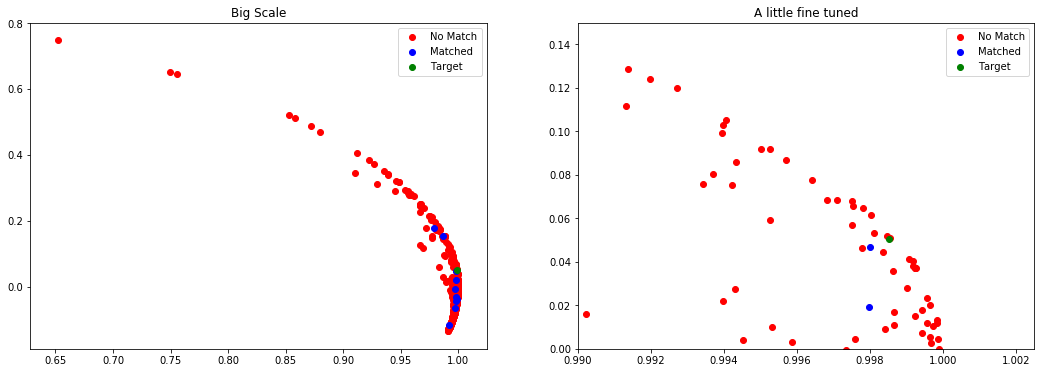

In [38]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.scatter(combined_svd[12:, 0], combined_svd[12:, 1], color='red', label='No Match')
plt.scatter(combined_svd[1:11, 0], combined_svd[1:11, 1], color='blue', label='Matched')
plt.scatter(combined_svd[0, 0], combined_svd[0, 1], color='green', label='Target')
plt.legend()
plt.title('Big Scale')

plt.subplot(1, 2, 2)
plt.scatter(combined_svd[12:, 0], combined_svd[12:, 1], color='red', label='No Match')
plt.scatter(combined_svd[1:11, 0], combined_svd[1:11, 1], color='blue', label='Matched')
plt.scatter(combined_svd[0, 0], combined_svd[0, 1], color='green', label='Target')
plt.xlim(0.99, 1.0025)
plt.ylim(0.0, 0.15)
plt.legend()
plt.title('A little fine tuned')
plt.show()

## Model Evaluation

So, how close are these hikes to our targets?

We will visualize our results in a 2D plot via dimensionality reduction.

In [39]:
#only use certain columns
columns = ['name', 'summary', 'difficulty', 'stars', 'location', 'length', 'ascent', 'descent', 'high', 'low']

#our target df
target_hike_name = df['name'][0]
target_df = df.loc[df.name == target_hike_name][columns]
target_df = df_cleaner(target_df)

#every hike from our API request
all_hikes = df_cleaner(get_hikes('Austin', 'Texas', 150, 10))

#our ten recommendations                       
recommended_df = similar_hikes(all_hikes, target_hike_name)

#the rest of all hikes that didn't match
no_match = all_hikes.loc[~all_hikes.name.isin(recommended_df.name)]

#put 'em all together!
combined_df = pd.concat([target_df, recommended_df, no_match]).reset_index(drop=True)

In [40]:
vectorizer = CountVectorizer(stop_words='english', max_features=50)
vector = vectorizer.fit_transform(combined_df['sent_combined'])
vec_col = vectorizer.get_feature_names()

bow = pd.DataFrame(vector.toarray(), columns=vec_col)

combined_df = pd.concat([combined_df, bow], axis=1)

combined_df = combined_df.drop(columns=['name', 'summary', 'sent_combined', 'difficulty', 'location'])

In [41]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

normalize = Normalizer()
svd = TruncatedSVD()

reduce = make_pipeline(normalize, svd)

combined_svd = reduce.fit_transform(combined_df)

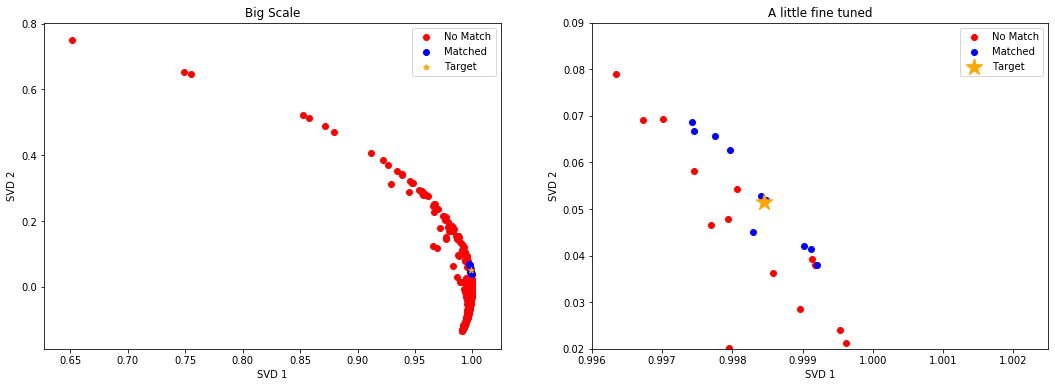

In [43]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.scatter(combined_svd[12:, 0], combined_svd[12:, 1], color='red', label='No Match')
plt.scatter(combined_svd[1:11, 0], combined_svd[1:11, 1], color='blue', label='Matched')
plt.scatter(combined_svd[0, 0], combined_svd[0, 1], color='orange', marker='*', label='Target')
plt.xlabel('SVD 1')
plt.ylabel('SVD 2')
plt.legend()
plt.title('Big Scale')

plt.subplot(1, 2, 2)
plt.scatter(combined_svd[12:, 0], combined_svd[12:, 1], color='red', label='No Match')
plt.scatter(combined_svd[1:11, 0], combined_svd[1:11, 1], color='blue', label='Matched')
plt.scatter(combined_svd[0, 0], combined_svd[0, 1], color='orange', marker='*', s=300, label='Target')
plt.xlim(0.996, 1.0025)
plt.ylim(0.02, 0.09)
plt.xlabel('SVD 1')
plt.ylabel('SVD 2')
plt.legend()
plt.title('A little fine tuned')
plt.show()

## KMeans Clustering

So, let's try a different approach. Namely, we'll add a step.

After we get our filtered subset, we'll perform some KMeans clustering. We'll return all the hikes that have the same label as our target, then perform our cosine matrix.

In [44]:
from sklearn.cluster import KMeans

def clustered_hikes(data2, name):
    #add our named hike to our df - if it's not their already
    name_df = df.loc[df.name == name, ['name', 'summary', 'difficulty', 'stars', 'location', 'length', 'ascent', 'descent', 'high', 'low']]
    if len(data2.loc[data2.name == name]) == 0:
        name_df = df_cleaner(name_df)
        data2 = data2.append(name_df, ignore_index=True)
    
    #vectorizer our sent_combined column
    vectorizer = CountVectorizer(stop_words='english', max_features=50)
    vector = vectorizer.fit_transform(data2['sent_combined'])
    columns = vectorizer.get_feature_names()
    
    #create our bag of words and combine with other features from the hike
    bow = pd.DataFrame(vector.toarray(), columns=columns)
    partial_df = data2[['stars', 'length', 'ascent', 'descent', 'high', 'low', 'name']]
    
    #create our features
    X = pd.concat([bow, partial_df], axis=1)
    
    #Kmeans Clustering
    kmeans = KMeans(n_clusters=2, algorithm='full')
    model = kmeans.fit(X.drop(columns='name'))
    #our labels
    labels = model.labels_
    partial_df['labels'] = labels
    
    #our recommended_hikes should have the same label as our target
    target_label = int(partial_df.loc[partial_df.name == name]['labels'])
    recommended_index = partial_df.loc[partial_df.labels == target_label].index.tolist()
    
    return data2.iloc[recommended_index, :]

In [45]:
start_time  = time.time()

test_df = get_hikes('Austin', 'Texas', 150, 10)
test_df = df_cleaner(test_df)
cluster_df = clustered_hikes(test_df, df['name'][0])
cluster_df = similar_hikes(cluster_df.reset_index(drop=True), df['name'][0])
print('This ran in {} seconds'.format(time.time() - start_time))

This ran in 5.028660535812378 seconds


So, it takes about as long. How does it perform?

## Evaluate our Clustering Method

In [46]:
#only use certain columns
columns = ['name', 'summary', 'difficulty', 'stars', 'location', 'length', 'ascent', 'descent', 'high', 'low']

#our target df
target_hike_name = df['name'][0]
target_df = df.loc[df.name == target_hike_name][columns]
target_df = df_cleaner(target_df)

#every hike from our API request
all_hikes = df_cleaner(get_hikes('Austin', 'Texas', 150, 10))

#our ten recommendations                       
recommended_df = clustered_hikes(all_hikes, target_hike_name)
recommended_df = similar_hikes(recommended_df.reset_index(drop=True), target_hike_name)

#the rest of all hikes that didn't match
no_match = all_hikes.loc[~all_hikes.name.isin(recommended_df.name)]

#put 'em all together!
combined_df = pd.concat([target_df, recommended_df, no_match]).reset_index(drop=True)

In [47]:
vectorizer = CountVectorizer(stop_words='english', max_features=50)
vector = vectorizer.fit_transform(combined_df['sent_combined'])
vec_col = vectorizer.get_feature_names()

bow = pd.DataFrame(vector.toarray(), columns=vec_col)

combined_df = pd.concat([combined_df, bow], axis=1)

combined_df = combined_df.drop(columns=['name', 'summary', 'sent_combined', 'difficulty', 'location'])

In [48]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

normalize = Normalizer()
svd = TruncatedSVD()

reduce = make_pipeline(normalize, svd)

combined_svd = reduce.fit_transform(combined_df)

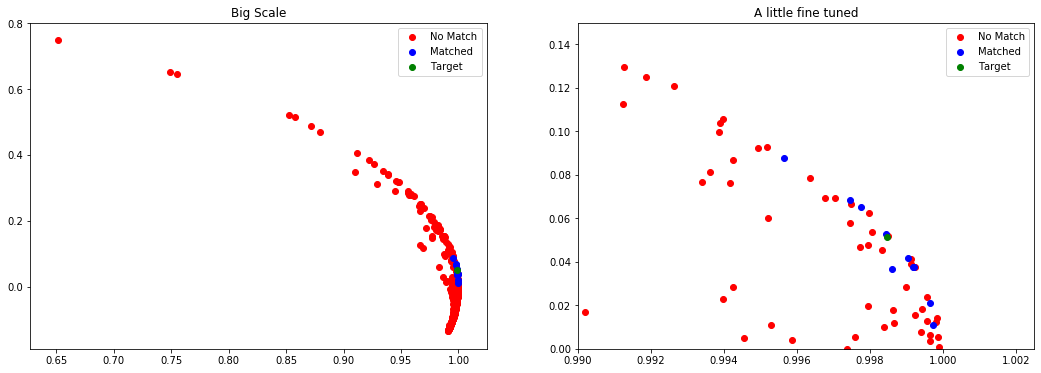

In [49]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.scatter(combined_svd[12:, 0], combined_svd[12:, 1], color='red', label='No Match')
plt.scatter(combined_svd[1:11, 0], combined_svd[1:11, 1], color='blue', label='Matched')
plt.scatter(combined_svd[0, 0], combined_svd[0, 1], color='green', label='Target')
plt.legend()
plt.title('Big Scale')

plt.subplot(1, 2, 2)
plt.scatter(combined_svd[12:, 0], combined_svd[12:, 1], color='red', label='No Match')
plt.scatter(combined_svd[1:11, 0], combined_svd[1:11, 1], color='blue', label='Matched')
plt.scatter(combined_svd[0, 0], combined_svd[0, 1], color='green', label='Target')
plt.xlim(0.99, 1.0025)
plt.ylim(0.0, 0.15)
plt.legend()
plt.title('A little fine tuned')
plt.show()

This seems to be close, but not close enough compared to others.

## Matching Hikes from Keywords

For this, we'll use the same techniques for returning a filtered subset. We'll then perform some basic NLP (removing stop words and punctuation).

Then users will input keywords (as strings). Our function will use Word2Vec to  return the best matches of our summaries and keywords.

#### Deeper dive into our summary

Before that, let's take a deeper dive into our summaries.

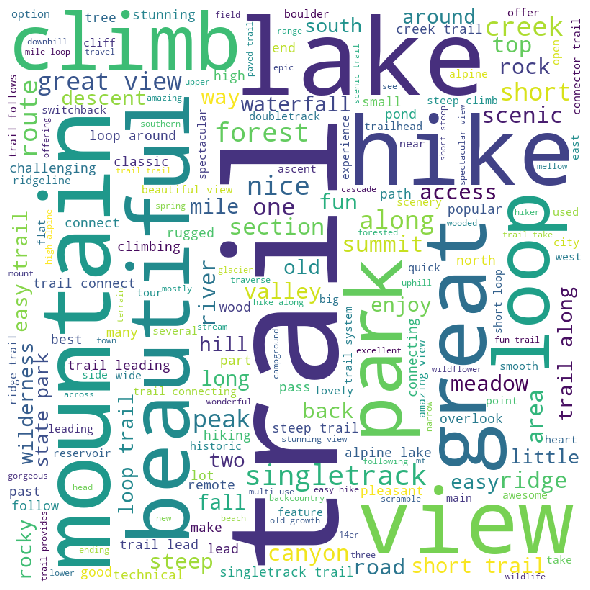

In [50]:
from wordcloud import WordCloud, STOPWORDS 

comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.summary: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [51]:
#some keywords based on our wordcloud + intuition
keywords = ['short', 'mountain', 'river', 'forest', 'beautiful', 'challenging', 'water', 'flower', 'easy']

In [52]:
from gensim.summarization.summarizer import summarize

large_combined = ''

for i in range(len(df)):
    sentence = df['summary'][i]
    if i != 0:
        large_combined = large_combined + '. ' + sentence
    else: 
        large_combined = large_combined + sentence

What 50 words best summarize our dataset?

In [53]:
#what 50 word sentences best summarizes our corpus?
summarize(large_combined, word_count=50)

'a short, moderately steep hike up red butte with sandstone slab furniture and great views of the salt lake valley..\na short, rocky climb providing access to a beautiful loop with views and forest..\nthis forested loop up acadia mountain is one of the most popular hikes in the park with great views..'

In [54]:
#let's add a few more words
words = ['steep', 'view', 'breathtaking', 'popular']

for word in words:
    keywords.append(word)

## Recommender with keyword matching

First, we'll want to make a new feature that performs some NLP on our data.

In [55]:
import gensim.downloader as api
import spacy

word_vectors = api.load("glove-wiki-gigaword-100")
nlp = spacy.load('en_core_web_sm')

In [56]:
def perform_nlp(nlp_data):
    sentences = []
    #first do some NLP on each sentence as a list
    for sentence in nlp_data['summary']:
        sentence = nlp(sentence)
        sentence = [
            token.lemma_.lower()
            for token in sentence
            if not token.is_stop
            and not token.is_punct
        ]
        sentences.append(sentence)
    
    #add list of NLP words to our df    
    nlp_data['nlp_summary'] = sentences
    
    return nlp_data

Now time to make our keyword matching hikes!

In [57]:
def keyword_hikes(keyword_df, keywords):
    scores = []
    #let's do some cleaning of our nlp_summary
    for i in range(len(keyword_df)):
        #make sure each word in nlp_summary is in our word_vector
        sentence = []
        for word in keyword_df['nlp_summary'][i]:
            if word in word_vectors.vocab.keys():
                sentence.append(word)
                
        #score our keywords with our vector
        scores.append(word_vectors.n_similarity(sentence, keywords))

    keyword_df['scores'] = scores
    
    keyword_df = keyword_df.sort_values(by='scores', ascending=False)
    
    return keyword_df[:10][['name', 'summary', 'difficulty', 'stars', 'location', 'length', 'ascent', 'descent', 'high', 'low']]        

In [58]:
start_time = time.time()

test_df = get_hikes('Denver', 'Colorado', 150, 10)
test_df = df_cleaner(test_df)
test_df = perform_nlp(test_df)
kword_match = keyword_hikes(test_df, ['easy', 'water'])
print('This ran in {} seconds'.format(time.time() - start_time))
kword_match


This ran in 13.57407021522522 seconds


,name,summary,difficulty,stars,location,length,ascent,descent,high,low
252,Crater Lakes Trail #819,this is a great place to camp on a hot summer ...,blue,4.4,"Winter Park, Colorado",1.1,700,-13,10663,9976
40,Mohawk Lakes,a fairly easy hike providing awesome views fro...,blue,4.6,"Breckenridge, Colorado",4.3,1267,-1266,12395,11133
213,Herman Gulch Trail #98,quickly earn some amazing mountain views and s...,blue,4.6,"Georgetown, Colorado",3.3,1692,-32,11989,10309
134,Golden Cliffs Loop,"starting from a less-crowded lot, this offers ...",blue,4.5,"Golden, Colorado",1.6,529,-536,6431,5896
192,Fourmile Creek - Gold Hill Connection,a solid hike with a good mix of open space and...,greenBlue,3.8,"Nederland, Colorado",4.9,781,-782,9126,8715
88,Green Mountain Tour,a good hike with easy front range access. som...,blue,3.8,"West Pleasant View, Colorado",5.4,909,-900,6854,6132
328,Twin Lakes Trail #402,fairly easy trail to a beautiful place. contin...,greenBlue,5.0,"Crested Butte, Colorado",2.9,1487,-8,11900,10419
244,East Inlet Trail,a relatively easy trail with beautiful views o...,blue,4.5,"Grand Lake, Colorado",7.9,2170,-549,10444,8420
77,Hewlett Gulch Trail #954,a fun trail to let your dog off the leash with...,greenBlue,4.3,"Laporte, Colorado",8.4,1125,-1125,6797,5729
238,Fern Lake Trail,"a two-faced (easy, then very hard) trail that ...",blue,4.2,"Estes Park, Colorado",3.5,1341,-27,9466,8151


## Model Evaluation

Wow, so this takes significantly longer than our target-hike method. I wonder how this performed? Let's do some cursory examination of our summaries and then visualize our results using our 2D method.

In [59]:
for summary in kword_match.summary:
    print(summary)
    print('')

this is a great place to camp on a hot summer day. come for the views, but stay for the cool water and the upper lake.

a fairly easy hike providing awesome views from a high alpine lake.

quickly earn some amazing mountain views and slowly gain an alpine lake on this easy-to-access route

starting from a less-crowded lot, this offers rougher terrain and easy climbing access. great views of downtown golden.

a solid hike with a good mix of open space and tree cover, single and doubletrack trail, and a couple of scenic views.

a good hike with easy front range access.  some steep climbs, rocks and nice views.

fairly easy trail to a beautiful place. continue up to the ridgeline for even better views.

a relatively easy trail with beautiful views of lakes and peaks.

a fun trail to let your dog off the leash with many water crossings to romp through.

a two-faced (easy, then very hard) trail that leads to a stunning waterfall and serene alpine lake.



We'll take a similar approach to this model's evaluation as we did previously.

Let's focus on our bow, since this is what the model uses to evaluate.

In [60]:
#all hikes from our API request
all_hikes = perform_nlp(df_cleaner(get_hikes('Denver', 'Colorado', 150, 10)))

#our ten recommendations                       
recommended_df = keyword_hikes(all_hikes, ['easy', 'water'])
recommended_df = df_cleaner(recommended_df)

#the rest of all hikes that didn't match
no_match = all_hikes.loc[~all_hikes.name.isin(recommended_df.name)]
no_match = no_match.drop(columns=['nlp_summary', 'scores'])

combined_df = pd.concat([recommended_df, no_match]).reset_index(drop=True)

In [61]:
vectorizer = CountVectorizer(stop_words='english', max_features=50)
vector = vectorizer.fit_transform(combined_df['sent_combined'])
vec_col = vectorizer.get_feature_names()

bow = pd.DataFrame(vector.toarray(), columns=vec_col)

In [62]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

normalize = Normalizer()
svd = TruncatedSVD()

reduce = make_pipeline(normalize, svd)

combined_svd = reduce.fit_transform(bow)

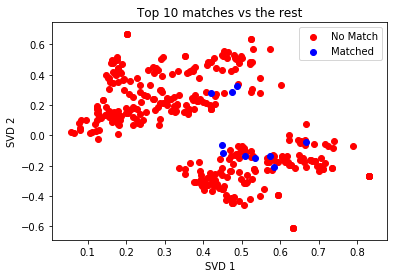

In [63]:
plt.scatter(combined_svd[11:, 0], combined_svd[11:, 1], color='red', label='No Match')
plt.scatter(combined_svd[:10, 0], combined_svd[:10, 1], color='blue', label='Matched')
plt.xlabel('SVD 1')
plt.ylabel('SVD 2')
plt.legend()
plt.title('Top 10 matches vs the rest')
plt.show()

This doesn't seem to perform as well as our target-hike method. This isn't surprising as there is less information to use.